In [12]:
#importing libraries..
import pandas as pd
import pyspark
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [13]:
#loading data from s3 bucket
filepath = "s3a://geo-project-data/devicestatus/devicestatus.txt"

#preprocessing txt file --> file contains multiple delimiters which are all replaces by ',' and split by ','
df = sc.textFile(filepath).map(lambda x: x.replace('|',',').replace('/',',').split(',')).toDF()

#display spark dataframe
df.show()

+-------------------+--------------------+--------------------+---+---+---+-------+---------+---------+---------+--------+---------+-------------+--------------+
|                 _1|                  _2|                  _3| _4| _5| _6|     _7|       _8|       _9|      _10|     _11|      _12|          _13|           _14|
+-------------------+--------------------+--------------------+---+---+---+-------+---------+---------+---------+--------+---------+-------------+--------------+
|2014-03-15:10:10:20|       Sorrento F41L|8cc3b47e-bd01-448...|  7| 24| 39|enabled| disabled|connected|       55|      67|       12|33.6894754264|-117.543308253|
|2014-03-15:10:10:20|          MeeToo 1.0|ef8c7564-0a1a-465...|  0| 31| 63|     70|       39|       27|  enabled| enabled|  enabled|37.4321088904|-121.485029632|
|2014-03-15:10:10:20|          MeeToo 1.0|23eba027-b95a-472...|  0| 20| 21|     86|       54|       34|  enabled| enabled|  enabled|39.4378908349|-120.938978486|
|2014-03-15:10:10:20|       

In [14]:
#Extracting the date (first field), model (second field), device ID (third field), and latitude
#and longitude (13th and 14th fields respectively)

deviceDF = df.select(df._13.alias("latitude"),
  df._14.alias("longitude"),
  df._1.alias("date"),
  df._2.alias("model"),
  df._3.alias("deviceID"))

In [15]:
deviceDF.show()

+-------------+--------------+-------------------+--------------------+--------------------+
|     latitude|     longitude|               date|               model|            deviceID|
+-------------+--------------+-------------------+--------------------+--------------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|       Sorrento F41L|8cc3b47e-bd01-448...|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|          MeeToo 1.0|ef8c7564-0a1a-465...|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|          MeeToo 1.0|23eba027-b95a-472...|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|       Sorrento F41L|707daba1-5640-4d6...|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Ronin Novelty Note 1|db66fe81-aa55-43b...|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|       Sorrento F41L|ffa18088-69a0-433...|
|37.3803954321|-121.840756755|2014-03-15:10:10:20|       Sorrento F33L|66d678e6-9c87-48d...|
|34.1841062345|  -117.9435329|2014-03-15:10:10:20|          MeeToo 4.1

In [16]:
#Filtering out locations that have a latitude and longitude of 0
deviceDF = deviceDF.filter((deviceDF.latitude != 0) | (deviceDF.longitude != 0))

In [17]:
#Splitting model field by spaces to separate the manufacturer columns

split_col = pyspark.sql.functions.split(deviceDF['model'], ' ')
deviceDF = deviceDF.withColumn('manufacturer', split_col.getItem(0))
deviceDF = deviceDF.withColumn('model', split_col.getItem(1))

In [18]:
deviceDF.show()

+-------------+--------------+-------------------+-------+--------------------+------------+
|     latitude|     longitude|               date|  model|            deviceID|manufacturer|
+-------------+--------------+-------------------+-------+--------------------+------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|   F41L|8cc3b47e-bd01-448...|    Sorrento|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|    1.0|ef8c7564-0a1a-465...|      MeeToo|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|    1.0|23eba027-b95a-472...|      MeeToo|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|   F41L|707daba1-5640-4d6...|    Sorrento|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Novelty|db66fe81-aa55-43b...|       Ronin|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|   F41L|ffa18088-69a0-433...|    Sorrento|
|37.3803954321|-121.840756755|2014-03-15:10:10:20|   F33L|66d678e6-9c87-48d...|    Sorrento|
|34.1841062345|  -117.9435329|2014-03-15:10:10:20|    4.1|673f7e4b-d52

In [19]:
deviceDF.count()

94039

In [ ]:
#Save the extracted data to comma delimited text files in S3.

deviceDF.write.csv("s3a://geo-project-data/devicestatus/output", header = True)

# Visualization

In [21]:
#converting spark dataframe to pandas dataframe
df_pd = deviceDF["latitude","longitude"].toPandas()

In [22]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import descartes

In [23]:
df_pd.head()

,latitude,longitude
0,33.6894754264,-117.543308253
1,37.4321088904,-121.485029632
2,39.4378908349,-120.938978486
3,39.3635186767,-119.400334708
4,33.1913581092,-116.448242643


In [24]:
#converting latitude and longitude values to float
latitude = []
longitude = []
for i,j in zip(df_pd.latitude,df_pd.longitude):
    latitude.append(float(i))
    longitude.append(float(j))

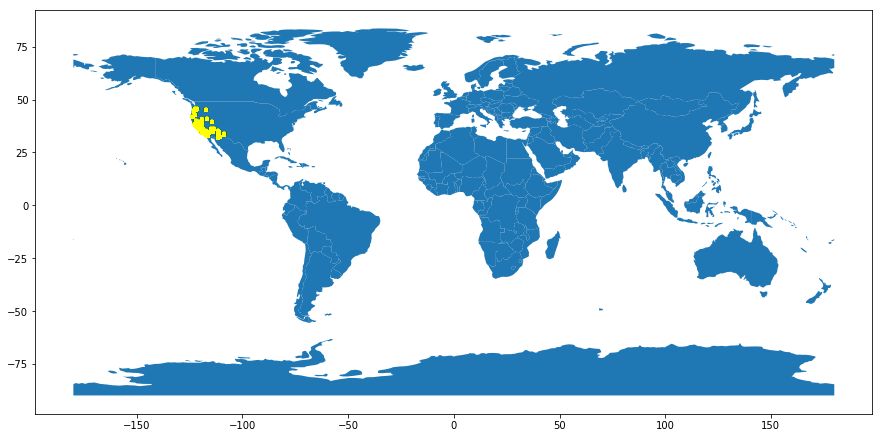

In [25]:
#plotting map using geopandas

gdf = gpd.GeoDataFrame(df_pd, geometry=gpd.points_from_xy(longitude, latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(15,15))

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='yellow',figsize=(15,15), marker='*', markersize=5)

plt.show()

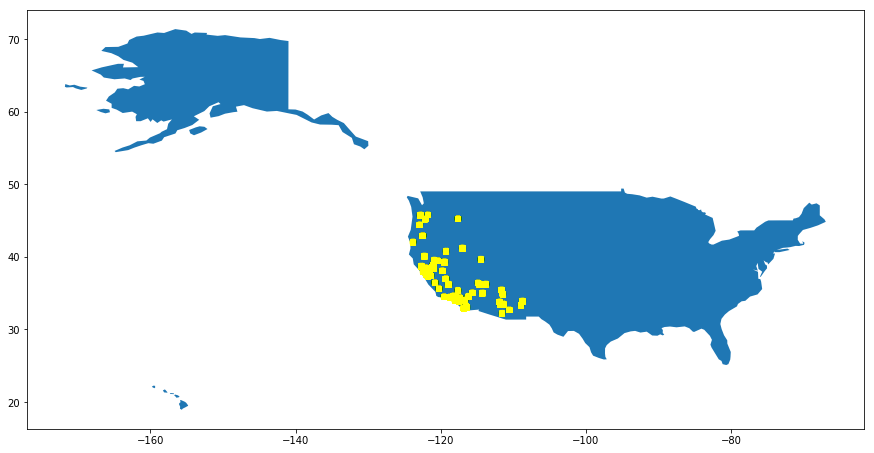

In [27]:
#united states map..

gdf = gpd.GeoDataFrame(df_pd, geometry=gpd.points_from_xy(longitude, latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'United States of America'].plot(figsize=(15,15))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='yellow',figsize=(15,15), marker='*', markersize=5)

plt.show()